In [1]:
!pip install gradio


In [2]:
# Hücre 1: Gerekli Kütüphaneler
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gradio import
import gradio as gr

# Türkçe stopwords
turkce_stopwords = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrnck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hücre 2: Temizleme Fonksiyonu
def temizle(yorum):
    yorum = str(yorum).lower()
    yorum = re.sub(r"http\S+", "", yorum)
    yorum = re.sub(r"[^a-zçğıöşü0-9\s]", "", yorum)
    yorum = re.sub(r"\s+", " ", yorum).strip()
    yorum = " ".join([w for w in yorum.split() if w not in turkce_stopwords])
    return yorum

In [4]:
# Hücre 3: Veriyi Yükle ve Temizle
df = pd.read_csv("eticaret-urun-yorumlari.csv", sep=";")
df.columns = ["Metin", "Durum"]
df = df[df["Durum"].isin([0, 1])]
df["temiz_yorum"] = df["Metin"].apply(temizle)
df = df[df['temiz_yorum'].str.len() > 5]
df.head()


,Metin,Durum,temiz_yorum
0,evet anlatıldığı gibi,1,evet anlatıldığı
1,Daha öncede almıştım bu cihazdan ense ve sakal...,1,öncede almıştım cihazdan ense sakal tüketmek o...
2,Ürün gayet başarılı sakal kesmede başlık sayıs...,1,ürün gayet başarılı sakal kesmede başlık sayıs...
3,Daha öncede aynısını almıştım çok güzel ve kal...,1,öncede aynısını almıştım güzel kaliteli bir ürün
4,Erkek kuaförüyüm ense ve sıfır sakal traşı içi...,1,erkek kuaförüyüm ense sıfır sakal traşı uygun ...


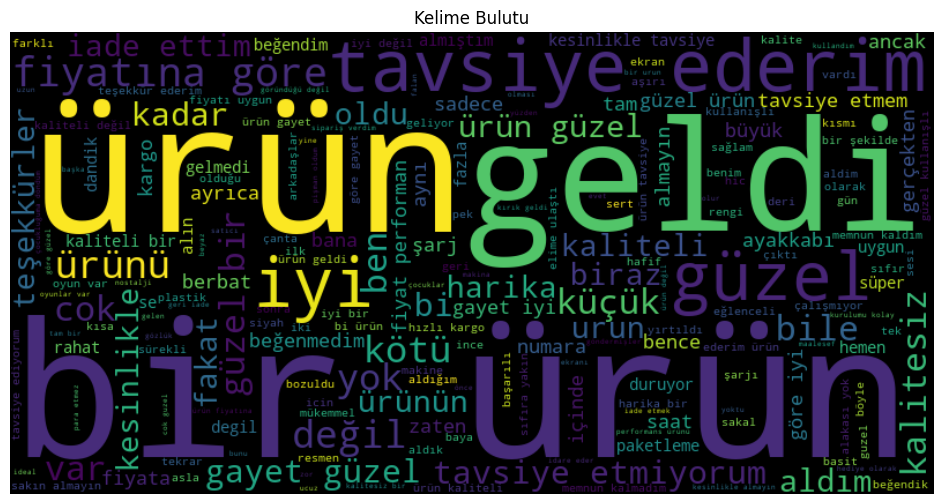

In [5]:
# Hücre 4: WordCloud
wc = WordCloud(width=800, height=400).generate(" ".join(df["temiz_yorum"]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Kelime Bulutu")
plt.show()

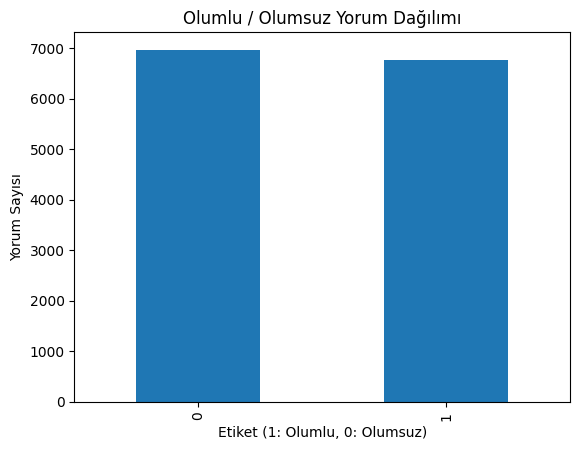

In [6]:
# Hücre 5: Olumlu-Olumsuz Dağılım
df["Durum"].value_counts().plot(kind="bar")
plt.title("Olumlu / Olumsuz Yorum Dağılımı")
plt.xlabel("Etiket (1: Olumlu, 0: Olumsuz)")
plt.ylabel("Yorum Sayısı")
plt.show()

In [7]:
# Hücre 6: Eğitim/Test Ayrımı ve Model Eğitimi (Naive Bayes)
X_train, X_test, y_train, y_test = train_test_split(df["temiz_yorum"], df["Durum"], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

y_pred_nb = model_nb.predict(X_test_vec)
print("Naive Bayes Doğruluk:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Doğruluk: 0.9530054644808743
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1378
           1       0.94      0.96      0.95      1367

    accuracy                           0.95      2745
   macro avg       0.95      0.95      0.95      2745
weighted avg       0.95      0.95      0.95      2745



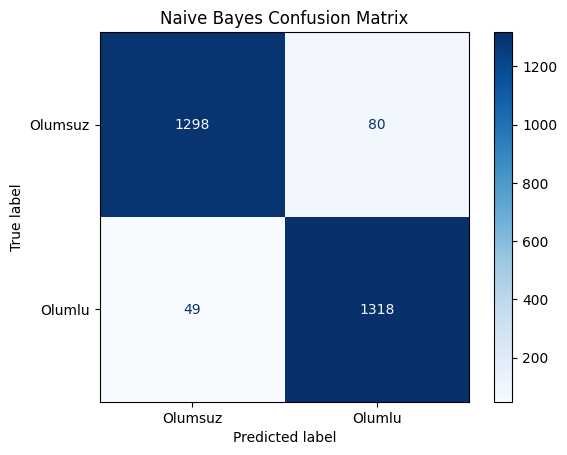

In [8]:
# Hücre 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Olumsuz", "Olumlu"])
disp.plot(cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.show()


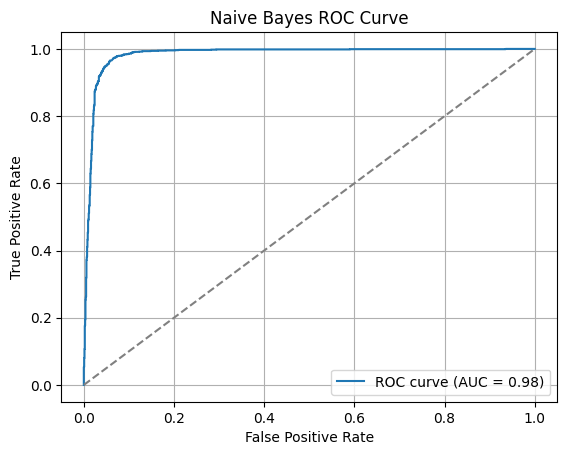

In [9]:
# Hücre 8: ROC Curve
y_probs = model_nb.predict_proba(X_test_vec)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Hücre 9: Tahminleri Kaydet
df["tahmin"] = model_nb.predict(vectorizer.transform(df["temiz_yorum"]))
df["dogru_mu"] = df["Durum"] == df["tahmin"]
df.to_csv("yorum_tahmin_sonuclari.csv", index=False)
print("📁 Tahmin sonuçları 'yorum_tahmin_sonuclari.csv' dosyasına kaydedildi.")


📁 Tahmin sonuçları 'yorum_tahmin_sonuclari.csv' dosyasına kaydedildi.


In [11]:
# Hücre 10: Model Karşılaştırması (Logistic Regression & SVM)
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_vec, y_train)
y_pred_lr = model_lr.predict(X_test_vec)
print("\nLogistic Regression Doğruluk:", accuracy_score(y_test, y_pred_lr))

model_svm = LinearSVC()
model_svm.fit(X_train_vec, y_train)
y_pred_svm = model_svm.predict(X_test_vec)
print("\nSVM Doğruluk:", accuracy_score(y_test, y_pred_svm))



Logistic Regression Doğruluk: 0.9566484517304189

SVM Doğruluk: 0.9500910746812387


In [12]:
# Hücre 11: TF-IDF ile Karşılaştırma
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model_tfidf_nb = MultinomialNB()
model_tfidf_nb.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = model_tfidf_nb.predict(X_test_tfidf)

print("\nTF-IDF Naive Bayes Doğruluk:", accuracy_score(y_test, y_pred_tfidf_nb))
print(classification_report(y_test, y_pred_tfidf_nb))



TF-IDF Naive Bayes Doğruluk: 0.9530054644808743
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1378
           1       0.95      0.96      0.95      1367

    accuracy                           0.95      2745
   macro avg       0.95      0.95      0.95      2745
weighted avg       0.95      0.95      0.95      2745



In [13]:
# Hücre 12: CountVectorizer vs TF-IDF Doğruluk Karşılaştırması
acc_count = accuracy_score(y_test, y_pred_nb)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf_nb)
print("\n🔍 Vektörleştirme Karşılaştırması")
print(f"CountVectorizer Doğruluk: {acc_count:.4f}")
print(f"TF-IDF           Doğruluk: {acc_tfidf:.4f}")


🔍 Vektörleştirme Karşılaştırması
CountVectorizer Doğruluk: 0.9530
TF-IDF           Doğruluk: 0.9530


In [14]:
# Hücre 13: Gradio ile Web Arayüzü
def tahmin_gradio(yorum):
    temiz = temizle(yorum)
    vektor = vectorizer.transform([temiz])
    tahmin = model_nb.predict(vektor)[0]
    return "Olumlu 😊" if tahmin == 1 else "Olumsuz 😞"

gr.Interface(
    fn=tahmin_gradio,
    inputs=gr.Textbox(lines=3, placeholder="Yorumunuzu buraya girin..."),
    outputs="text",
    title="Ürün Yorumlarından Duygu Tahmini",
    description="Bir yorum girin, model olumlu mu olumsuz mu olduğunu tahmin etsin."
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
